This is file runs the main calculation for the flexible length TPS simulation. It requires the file `alanine_dipeptide_tps_equil.nc`, which is written in the notebook `alanine_dipeptide_tps_first_traj.ipynb`.

In this file, you will learn:
* how to set up and run a flexible length TPS simulation

NB: This is a long calculation. In practice, it would be best to export the Python from this notebook, remove the `live_visualization`, and run non-interactively on a computing node.

In [1]:
import openpathsampling as paths

## Load engine, trajectory, and states from file

In [2]:
old_storage = paths.Storage("tps_nc_files/alanine_dipeptide_tps_equil.nc", "r")

In [3]:
engine = old_storage.engines[0]
alpha = old_storage.volumes.find('alpha')
beta = old_storage.volumes.find('beta')
traj = old_storage.samplesets[len(old_storage.samplesets)-1][0].trajectory
phi = old_storage.cvs.find('phi')
psi = old_storage.cvs.find('psi')
template = old_storage.snapshots[0]

In [5]:
engine.openmm_properties

{'OpenCLPrecision': 'mixed'}

In [4]:
engine.initialize('OpenCL')

Exception: This device does not support double precision

In [28]:
print engine.name

300K


## TPS

As always, the process for setting up a simulation is:

1. Create a `network`
2. Create a `move_scheme`
3. Set up `initial_conditions`
4. Create the `PathSampling` object and run it.

Since we already created all the input to these when we set up the first trajectory, we can load use the versions we loaded above.

In [6]:
network = paths.TPSNetwork(alpha, beta)

In [7]:
scheme = paths.OneWayShootingMoveScheme(network, selector=paths.UniformSelector(), engine=engine)

In [8]:
initial_conditions = scheme.initial_conditions_from_trajectories(traj)

# finished generating: still missing 0 samples
1


In [9]:
sampler = paths.PathSampling(storage=paths.Storage("tps_nc_files/alanine_dipeptide_tps.nc", "w", template),
                             move_scheme=scheme,
                             sample_set=initial_conditions)
sampler.live_visualization = paths.LiveVisualization(network, phi, psi, [-3.14, 3.14], [-3.14, 3.14])

In [10]:
sampler.live_visualization = None

Note: 10000 steps will take a long time. If you just want to run a little bit, reduce this number.

In [11]:
sampler.run(1500)

Working on Monte Carlo cycle number 1500
Running for 361 seconds -  4.15 steps per second
Expected time to finish: 0 seconds
DONE! Completed 1500 Monte Carlo cycles.


With this done, you can go on to do the flexible-length parts of the analysis in `alanine_dipeptide_tps_analysis.ipynb`.

In [11]:
st = sampler.storage

In [16]:
import numpy as np
import openpathsampling as p
import matplotlib.pyplot as plt

In [18]:
%matplotlib inline

In [15]:
l = []
r = []
m = []
first_l = None
for idx, step in enumerate(st.steps):
    ch = step.change
    nan = any(ch.map_pre_order(lambda x: isinstance(x, p.movechange.RejectedNaNSampleMoveChange)))
    if nan and first_l is None:
        first_l = idx
    l.append(nan)
    r.append(ch.accepted)
    vels = step.active[0].trajectory.velocities
    m.append(max(np.max(vels), np.max(-vels)))
    
print first_l

None


(-0.1, 1.1)

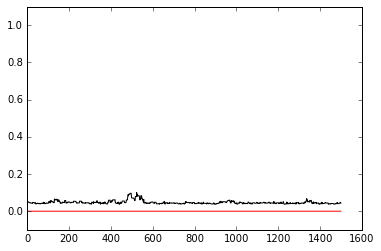

In [21]:
plt.plot(l[:1500], 'r')
# plt.plot(r[:200], 'b')
plt.plot([val._value / 150. for val in m[:1500]], 'k')
plt.ylim(-0.1, 1.1)

In [12]:
engine.openmm_properties

{'OpenCLPrecision': 'mixed'}

In [29]:
pl = engine.simulation.context.getPlatform()

In [30]:
for prop in pl.getPropertyNames():
    print prop, pl.getPropertyValue(engine.simulation.context, prop)

OpenCLDeviceIndex 1
OpenCLDeviceName HD Graphics 4000
OpenCLPlatformIndex 0
OpenCLPlatformName Apple
OpenCLPrecision single
OpenCLUseCpuPme false
OpenCLDisablePmeStream false
